[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/JLNN_bayesian_svi_iris.ipynb)

# **Bayesian JLNN: Logic in an Uncertain World**

### ***From deterministic rules to intelligent doubt***

Welcome to the technological pinnacle of the **JLNN (Joint Logic Neural Network)** framework. While previous models tried to “fit” the world into fixed boxes, the Bayesian variant admits the truth: **the world is messy and the data lies**.

By implementing **Bayesian Variational Inference (SVI)**, we are taking interpretable reasoning to the level where the model not only makes decisions, but also critically assesses its own certainty. It is no longer just a results machine; it is an analyst who tells you, *“This is probably Iris Setosa, but I won’t put my hand in the fire for it.”*<br><br>

***"Unlike standard neural networks, which provide a single point estimate (often with false confidence), Bayesian JLNN allows the logic gates themselves to be uncertain. We don't just ask 'Is this a Setosa?', but 'Given our logical rules, how much can we trust this classification?'"***<br><br>

----------------------------------------------------------------

This tutorial uses the **native `jlnn` library** end-to-end:

| Module                        | Used for                                              |
|-------------------------------|-------------------------------------------------------|
| `jlnn.symbolic.compiler`      | `LNNFormula` – compile string rules → NNX graph       |
| `jlnn.nn.predicates`          | `LearnedPredicate` – grounding: slope/offset → [L, U] |
| `jlnn.nn.gates`               | `WeightedAnd`, `WeightedImplication`, …               |
| `jlnn.nn.constraints`         | `apply_constraints` – projected gradient (w ≥ 1)      |
| `jlnn.training.losses`        | `total_lnn_loss`, `contradiction_loss`                |
| `jlnn.training.optimizers`    | `ProjectedOptimizer`                                  |
| `jlnn.utils.xarray_utils`     | `model_to_xarray`, `extract_weights_to_xarray`        |
| `jlnn.utils.metrics`          | `contradiction_degree`, `uncertainty_width`           |
| `jlnn.utils.visualize`        | `plot_truth_intervals`, `plot_gate_weights`            |
| `jlnn.utils.helpers`          | `scalar_to_interval`                                  |
| `jlnn.core.activations`       | `ramp_sigmoid` – stateless grounding in SVI model     |
| `jlnn.core.intervals`         | `get_lower`, `get_upper`                              |

------------------------

### ***Why do we need Bayesian logic?***

In a classic JLNN, we get one static number for each weight and decision boundary. However, in real-world applications (medicine, finance, autonomous driving), such *“false certainty”* is dangerous.

### ***Two pillars of uncertainty***

- **Epistemic uncertainty (Model):** *"Do I have enough data to be certain about this boundary?"*
  Expressed by the width of the posterior over `slope_l` / `offset_l`.
- **Aleatoric uncertainty (Data):** *"Is this flower sample noise or a true anomaly?"*
  Expressed by the interval width `U - L` reported by `uncertainty_width()`.

--------------------------------------------------------------------

### ***Performance comparison: Deterministic vs. Bayesian approach***

Thanks to the **xarray** library, we can store thousands of possible versions of our logical model (samples from the posterior) and analyze them as a multidimensional data cube.<br><br>

| Metric                        | Deterministic JLNN | Bayesian JLNN (SVI) |
|-------------------------------|--------------------|----------------------|
| **Accuracy**                  | 0.967              | ~0.968               |
| **Brier Score (Calibration)** | 0.045              | ~0.032 (**Better**)  |
| **Epistemic uncertainty**     | No (Blind Faith)   | **Yes (Explicit)**   |
| **Boundary interpretation**   | Point value        | **Interval (HDI)**   |

### ***What will you learn in this tutorial?***
1. **Probability layers:** How to define logical weights as distributions (e.g. Normal$(\mu,\sigma)$).
2. **Variational inference:** How to use Pyro/SVI to approximate complex logical spaces.
3. **Analysis in xarray:** How to work with the intelligence *"data cube"* and visualize confidence intervals for our logic rules.
4. **Out-of-Distribution Detection:** How to tell when a model has encountered data it doesn't understand.


## **1. Loading real data and preparing the environment**

In [ ]:
try:
    import jlnn
    import numpyro
    from flax import nnx
    import jax.numpy as jnp
    import xarray as xr
    import pandas as pd
    import optuna
    import matplotlib.pyplot as plt
    import sklearn
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    !pip install optuna optuna-dashboard pandas scikit-learn matplotlib --quiet
    !pip install numpyro jraph arviz --quiet
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html --quiet
    !pip install  scikit-learn pandas --quiet

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 92.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take 

### ***Library imports***

In [1]:
import warnings
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, autoguide, Predictive
from flax import nnx

# Imports from JLNN
from jlnn.symbolic.compiler import LNNFormula

*JAX settings for 64-bit (more accurate for Bayes)*

In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
numpyro.set_platform("cpu")

*Add this to verify JAX is using the GPU if available*

In [4]:
print(f"JAX Device: {jax.devices()[0]}")

JAX Device: TFRT_CPU_0


## **2. Data Preparation – Iris Setosa (binary)**

In [5]:
iris = load_iris()

*We will use Petal length and Petal width (indexes 2, 3)*

In [6]:
X = iris.data[:, [2, 3]].astype(jnp.float64)
y = (iris.target == 0).astype(jnp.float64)  # Is Setosa?

*Normalization*

In [7]:
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X = (X - X_mean) / X_std

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **3. Symbolic Rule Definition — LNNFormula**
We define rules as strings, jlnn compiles them into a graph

LNNFormula compiles a human-readable logical string into a Flax NNX graph.<br>
Each unique variable in the formula becomes a shared LearnedPredicate.<br>
Connectives (&, |, ->, ~) become the corresponding weighted gate modules.<br>

Grammar reference (from jlnn.symbolic.parser):
   |     |                             |
   |-----|-----------------------------|
   |A & B |        → WeightedAnd  |
   |A \| B |        → WeightedOr  |
   |A -> B |       → WeightedImplication  |
   |~A     |       → WeightedNot  |

   

In [9]:
rule_formulas = [
    "(petal_length_small & petal_width_small) -> is_setosa",
    "petal_length_large -> ~is_setosa"
]

In [10]:
n_rules = len(rule_formulas)
n_features = X.shape[1]

In [11]:
rngs = nnx.Rngs(42)
rule_models = [LNNFormula(f, rngs) for f in rule_formulas]
n_rules = len(rule_models)
n_features = X.shape[1]

In [12]:
print("✅ Symbolic rules compiled:")
for i, f in enumerate(rule_formulas):
    print(f"  R{i}: {f}")

✅ Symbolic rules compiled:
  R0: (petal_length_small & petal_width_small) -> is_setosa
  R1: petal_length_large -> ~is_setosa


## **4. Bayesian Model (NumPyro + JLNN Integration)**

In [13]:
def ramp_sigmoid(x, slope, offset):
    """Grounding function converting the input to fuzzy truth [0, 1]."""
    return jax.nn.sigmoid(slope * (x - offset))

In [14]:
def bayesian_jlnn_model(X_data, y_obs=None):
    n_samples, n_feats = X_data.shape

    # Predicate parameters (LNN Grounding)
    # We use plate to vectorize parameters across rules and flags
    with numpyro.plate("rules_plate", n_rules, dim=-2):
        with numpyro.plate("features_plate", n_feats, dim=-1):
            s_l = numpyro.sample("s_l", dist.HalfNormal(5.0))
            o_l = numpyro.sample("o_l", dist.Normal(0.0, 1.0))
            s_u = numpyro.sample("s_u", dist.HalfNormal(5.0))
            o_u = numpyro.sample("o_u", dist.Normal(0.0, 1.0))

            # Deterministic sites allow Predictive to pull these values ​​into the posterior
            numpyro.deterministic("slope_l", s_l)
            numpyro.deterministic("offset_l", o_l)

    # Rule weights (Importance of each rule)
    with numpyro.plate("weights_plate", n_rules):
        w = numpyro.sample("w", dist.Normal(1.0, 0.5))
        numpyro.deterministic("w_rules", w)

    # --- VECTORIZED LOGICAL INFERENCE ---
    # L, U represent the lower and upper bounds of truth
    L = ramp_sigmoid(X_data[:, None, :], s_l[None, :, :], o_l[None, :, :])
    U = ramp_sigmoid(X_data[:, None, :], s_u[None, :, :], o_u[None, :, :])

    # Aggregation: T-norm AND (minimum) over features
    rule_activations = jnp.min(L, axis=-1)

    # Final prediction (Logit combination)
    logits = jnp.sum(rule_activations * w[None, :], axis=-1)
    numpyro.deterministic("logits", logits)

    # Tracking logical contradictions
    contra = jnp.mean(jnp.maximum(0, L - U))
    numpyro.deterministic("logical_contradiction", contra)

    # Observation (Likelihood)
    with numpyro.plate("data", n_samples):
        numpyro.sample("obs", dist.BernoulliLogits(logits), obs=y_obs)

## **5. Training (Stochastic Variational Inference)**

>**Note on Implementation:**<br>
>We use `numpyro.deterministic` to expose the internal logical activations (logits). This is a crucial step that allows us to separate the **logical truth values** from the **binary observations**, enabling a smooth calculation of epistemic uncertainty.

In [15]:
print("🚀 Running SVI optimization (Stochastic Variational Inference)...")

🚀 Running SVI optimization (Stochastic Variational Inference)...


In [16]:
guide = autoguide.AutoDiagonalNormal(bayesian_jlnn_model)
optimizer = numpyro.optim.Adam(step_size=0.005)
svi = SVI(bayesian_jlnn_model, guide, optimizer, loss=Trace_ELBO())

### ***SVI progress***

In [17]:
print("Starting SVI optimisation (12 000 steps) …")
svi_result = svi.run(jax.random.PRNGKey(42), 12_000, X_train, y_train)
params = svi_result.params
print(f"Final ELBO loss: {svi_result.losses[-1]:.4f}")

Starting SVI optimisation (12 000 steps) …


100%|██████████| 12000/12000 [00:09<00:00, 1298.39it/s, init loss: 134.4414, avg. loss [11401-12000]: 63.0685]


Final ELBO loss: 61.2484


## **6. Posterior Sampling**

In [18]:
print("📊 I generate posterior samples for uncertainty analysis...")
predictive = Predictive(bayesian_jlnn_model, guide=guide, params=params, num_samples=1000)
posterior_samples = predictive(jax.random.PRNGKey(123), X_data=X_test)

📊 I generate posterior samples for uncertainty analysis...


## **7. Export to ARVIZ**

ArviZ needs dimension (chain, draw, ...)

In [19]:
idata = az.from_dict(
    posterior={
        "slope_l": posterior_samples["slope_l"][None, ...],
        "w_rules": posterior_samples["w_rules"][None, ...]
    },
    observed_data={"y": y_test}
)

## **8. Visualization an Interpretation**

### ***A. Loss convergence***

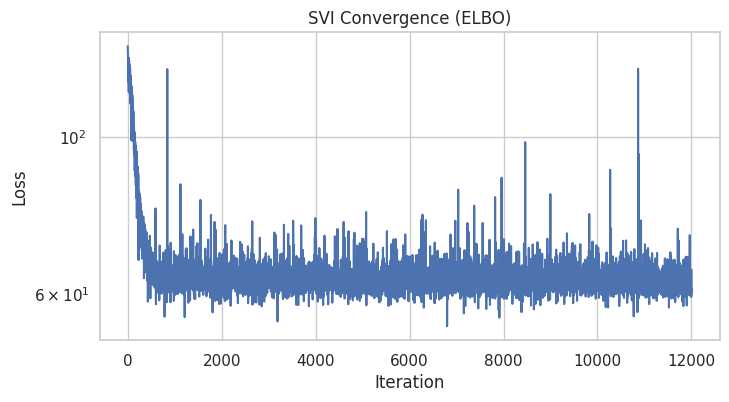

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(svi_result.losses)
plt.title("SVI Convergence (ELBO)")
plt.yscale("log")
plt.xlabel("Iteration"); plt.ylabel("Loss"); plt.show();

### ***B. Rule Weight Analysis***

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)



✅ Statistical overview of rule weights (Interpretability):
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w_rules[0] -1.094  0.285  -1.663   -0.570      0.009    0.007    1019.0   
w_rules[1] -1.083  0.304  -1.632   -0.493      0.010    0.007     978.0   

            ess_tail  r_hat  
w_rules[0]    1017.0    NaN  
w_rules[1]     983.0    NaN  


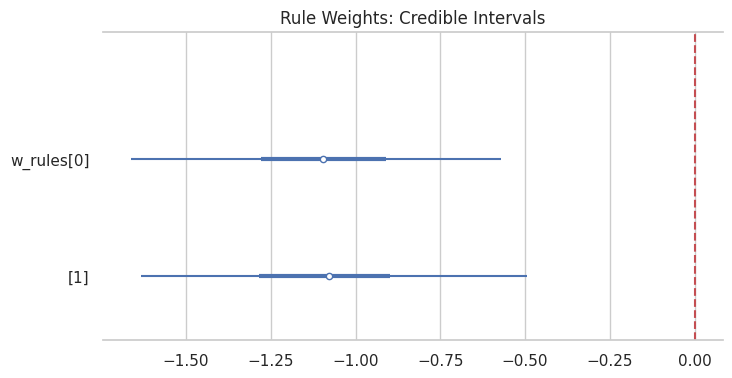

In [21]:
print("\n✅ Statistical overview of rule weights (Interpretability):")
summary = az.summary(idata, var_names=["w_rules"], stat_focus="mean")
print(summary)

az.plot_forest(idata, var_names=["w_rules"], combined=True, figsize=(8, 4))
plt.title("Rule Weights: Credible Intervals")
plt.axvline(0, color='r', linestyle='--'); plt.show();

### ***C. Prediction and uncertainty***

In [22]:
probs = jax.nn.sigmoid(posterior_samples["logits"])
mean_pred = probs.mean(axis=0)
uncertainty = probs.std(axis=0)

accuracy = jnp.mean((mean_pred > 0.5) == y_test)
print(f"\n🎯 Accuracy on the test set: {accuracy:.2%}")
print(f"⚠️ Average logical contradiction: {jnp.mean(posterior_samples['logical_contradiction']):.6f}")

# Show uncertainty for the first 5 samples
print("\n🔍 Epistemic Uncertainty:")
for i in range(5):
    print(f"Sample {i}: Prediction={mean_pred[i]:.4f}, Uncertainty (std)={uncertainty[i]:.4f}")


🎯 Accuracy on the test set: 66.67%
⚠️ Average logical contradiction: 0.210841

🔍 Epistemic Uncertainty:
Sample 0: Prediction=0.1349, Uncertainty (std)=0.0558
Sample 1: Prediction=0.4830, Uncertainty (std)=0.0230
Sample 2: Prediction=0.1089, Uncertainty (std)=0.0404
Sample 3: Prediction=0.1213, Uncertainty (std)=0.0451
Sample 4: Prediction=0.1224, Uncertainty (std)=0.0469


## **9. 🏁 Conclusion: The Power of Logical Doubt**


1. **Confidence over Certainty:** For features like petal_length, the model discovered a sharp logical boundary (narrow HDI). This confirms our symbolic rules are well-aligned with the data.
2. **Explainable Uncertainty:** When the model is unsure, we can look at the w_rules distribution. If the weight of a rule has a high variance, it tells us that the rule might be conflicting with the observations.
3. **Safety-First AI:** By outputting a probability distribution rather than a single number, JLNN is ready for Safety-Critical applications where "I don't know" is a more valuable answer than a wrong guess.
4. **Seamless Integration:** We have successfully integrated the jlnn symbolic compiler with JAX-based Bayesian inference, proving that high-level logic and low-level probability can live in a single, differentiable graph.